# Fake news detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,Russia notifies intent to suspend communicatio...,WASHINGTON (Reuters) - Russia has notified the...,politicsNews,"April 7, 2017",true
1,CNN’S FAREED ZAKARIA Busts Out a Profanity Fil...,,politics,"Mar 18, 2017",fake
2,Yemen's Hadi sees only a military solution to ...,DUBAI (Reuters) - A solution in Yemen s two an...,worldnews,"September 24, 2017",true
3,HILLARY LIES AGAIN…She’s NOT The First Female ...,"What a role model for women and young girls, a...",left-news,"Jun 9, 2016",fake
4,Putin Just Spit In America’s Face And Trump T...,"For more than 30 years, Donald Trump has built...",News,"August 10, 2017",fake


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Russia notifies intent to suspend communicatio...,WASHINGTON (Reuters) - Russia has notified the...,politicsNews,true
1,CNN’S FAREED ZAKARIA Busts Out a Profanity Fil...,,politics,fake
2,Yemen's Hadi sees only a military solution to ...,DUBAI (Reuters) - A solution in Yemen s two an...,worldnews,true
3,HILLARY LIES AGAIN…She’s NOT The First Female ...,"What a role model for women and young girls, a...",left-news,fake
4,Putin Just Spit In America’s Face And Trump T...,"For more than 30 years, Donald Trump has built...",News,fake


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - Russia has notified the...,politicsNews,true
1,,politics,fake
2,DUBAI (Reuters) - A solution in Yemen s two an...,worldnews,true
3,"What a role model for women and young girls, a...",left-news,fake
4,"For more than 30 years, Donald Trump has built...",News,fake


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - russia has notified the...,politicsNews,true
1,,politics,fake
2,dubai (reuters) - a solution in yemen s two an...,worldnews,true
3,"what a role model for women and young girls, a...",left-news,fake
4,"for more than 30 years, donald trump has built...",News,fake


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,washington reuters russia has notified the us...,politicsNews,true
1,,politics,fake
2,dubai reuters a solution in yemen s two andah...,worldnews,true
3,what a role model for women and young girls a ...,left-news,fake
4,for more than 30 years donald trump has built ...,News,fake


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\Aishwarya
[nltk_data]     kandhiah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,target
0,washington reuters russia notified usled coali...,politicsNews,true
1,,politics,fake
2,dubai reuters solution yemen two andahalf year...,worldnews,true
3,role model women young girls presidential cand...,left-news,fake
4,30 years donald trump built great negotiator g...,News,fake


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


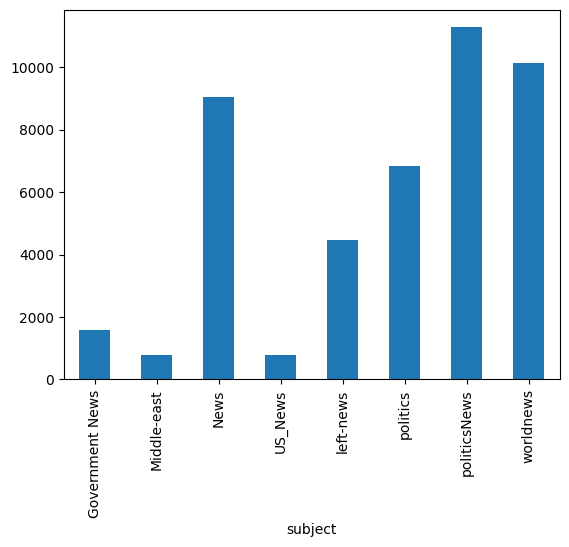

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64

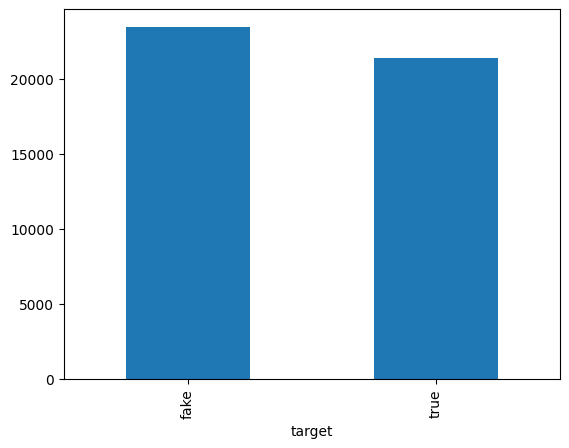

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

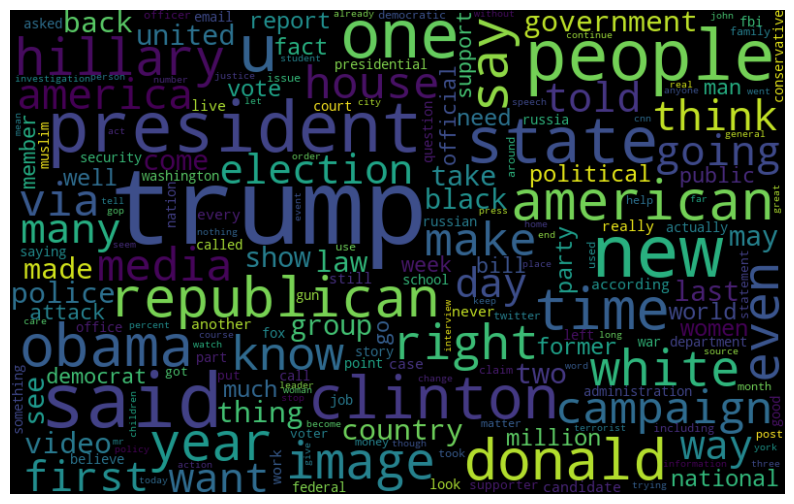

In [18]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

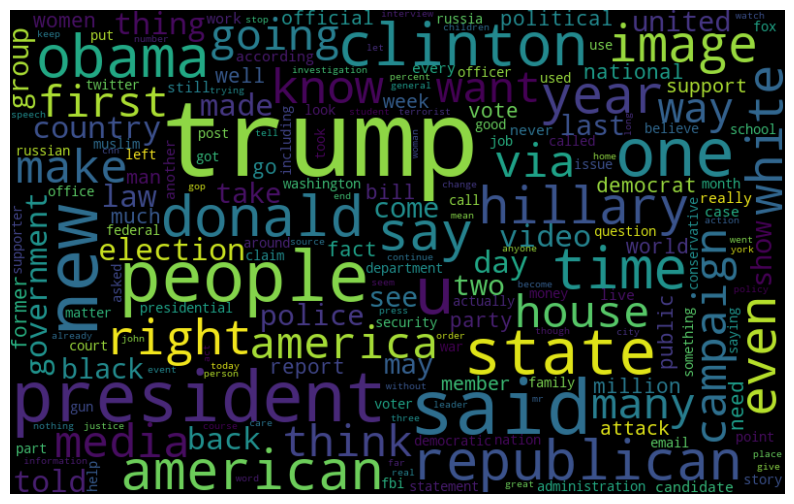

In [19]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

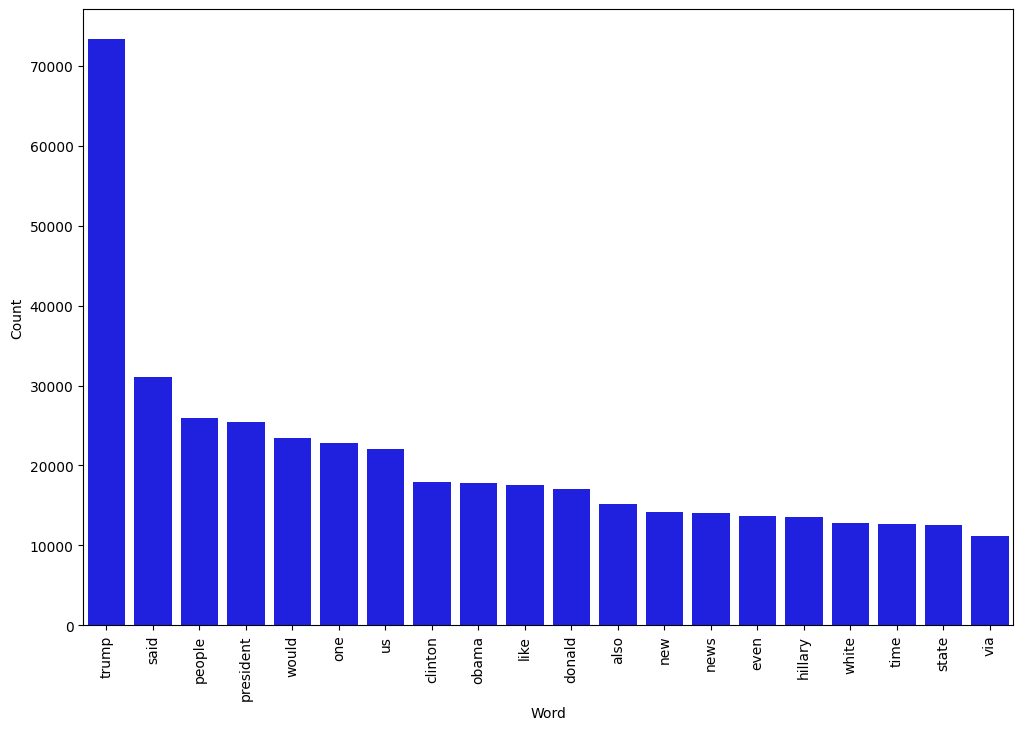

In [21]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

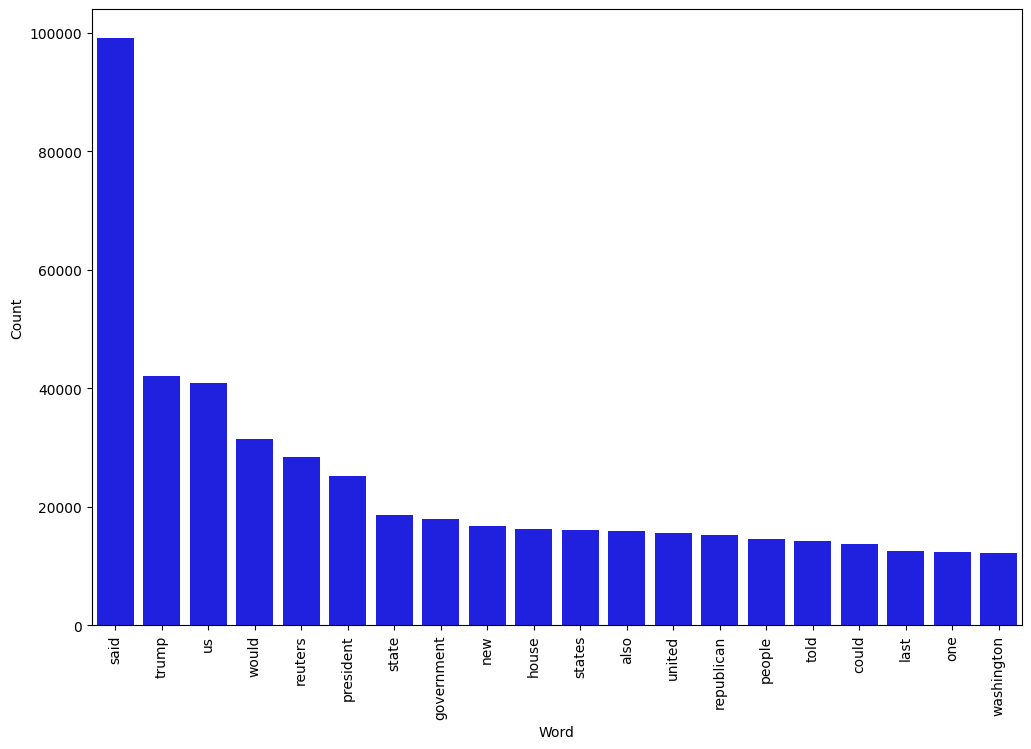

In [22]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [23]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [24]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [25]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.9%


Confusion matrix, without normalization


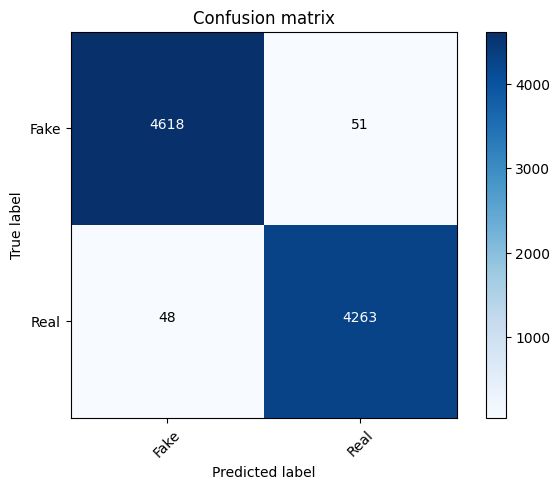

In [26]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [49]:
custom_text=[" New York governor questions the constitutionality of federal tax overhaul	NEW YORK/WASHINGTON (Reuters) - The new U.S. tax code targets high-tax states and may be unconstitutional, New York Governor Andrew Cuomo said on Thursday, saying that the bill may violate New York residentsâ€™ rights to due process and equal protection.  The sweeping Republican tax bill signed into law by U.S. President Donald Trump on Friday introduces a cap, of $10,000,  on deductions of state and local income and property taxes, known as SALT. The tax overhaul was the partyâ€™s first major legislative victory since Trump took office in January.  The SALT provision will hit many taxpayers in states with high incomes, high property values and high taxes, like New York, New Jersey and California. Those states are generally Democratic leaning.  â€œIâ€™m not even sure what they did is legally constitutional and thatâ€™s something weâ€™re looking at now,â€ Cuomo said in an interview with CNN. In an interview with CNBC, Cuomo suggested why the bill may be unconstitutional.  â€œPolitics does not trump the law,â€ Cuomo said on CNBC. â€œYou have the constitution, you have the law, you have due process, you have equal protection. You canâ€™t use politics just because the majority controls to override the law.â€ The Fifth Amendment of the Constitution, better known for its protection against self-incrimination, also protects individuals from seizure of life, liberty or property without due process and has been interpreted by the Supreme Court as guaranteeing equal protection by the law.  Cuomo and California Governor Jerry Brown, both Democrats, have previously said they were exploring legal challenges to SALT deduction limits.  Law professors have said legal challenges would likely rest on arguing that the provision interferes with the protection of statesâ€™ rights under the U.S. Constitutionâ€™s 10th Amendment. Tax attorneys said Cuomoâ€™s legal argument against the tax bill could be that it discriminates and places an unjust tax burden on states that heavily voted for Democrats in the past - known as â€œblue states.â€ â€œThe de facto effect of this legislation is to discriminate against blue states and particularly from (Cuomoâ€™s) perspective the state of New York,â€ said Joseph Callahan, an attorney with the law firm Mackay, Caswell & Callahan in New York.  But some tax experts noted the U.S. Supreme Court has interpreted the 16th Amendment to give Congress broad latitude to tax as it sees fit. In a frequently cited 1934 decision, the Supreme Court called tax deductions a â€œlegislative graceâ€ rather than a vested right. â€œI donâ€™t understand how they think they have a valid lawsuit here,â€ David Gamage, a professor of tax law at Indiana Universityâ€™s Maurer School of Law, told Reuters last week, speaking generally about governors in blue states that could challenge the tax bill.  Cuomo also said on Thursday that New York is proposing a restructuring of its tax code. He provided no details.  A group of 13 law professors on Dec. 18 published a paper suggesting ways that high-tax states could minimize the effects of the SALT deduction cap.  Their suggestions included shifting more of the tax burden onto businesses in the form of higher employer-side payroll taxes, since the federal tax billâ€™s cap on SALT deductions only applies to individuals and not businesses. States also could raise taxes on pass-through entities, which the federal tax bill specifically benefits with a lower rate on a portion of their income. On Friday, Cuomo said he would allow state residents to make a partial or full pre-payment on their property tax bill before Jan. 1, allowing taxpapyers to deduct such payments for 2017 before the cap kicks in, prompting a wave of residents to pay early.  However, the U.S. Internal Revenue Service on Wednesday advised homeowners that the pre-payment of 2018 property taxes may not be deductible. 	politicsNews	December 28, 2017 
 "] 

In [50]:
predicted_labels = model.predict(custom_text)

### Random Forest Classifier

In [51]:
print("Predicted labels:", predicted_labels)

Predicted labels: ['fake']
